In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.4.1


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


不卷积邻居信息，直接用node feature接MLP做分类效果不够好<br>
我们才会想着卷积

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [4]:

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [5]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


模型一个epoch把所有node都推理出一个预测<br>
整张图相当于一个batch<br>
但是算loss的时候只考虑了mask的，overfit了

In [6]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # dropout: 元素以一定概率变成 0 ；剩下的元素放大，以保持总体期望不变
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


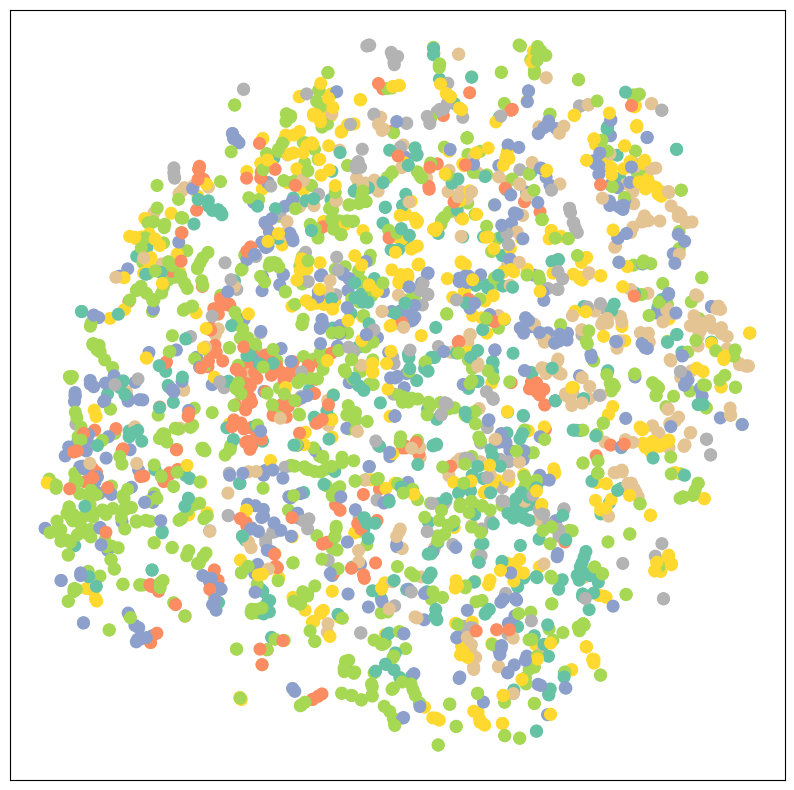

In [7]:
model = GCN(hidden_channels=16)
model.eval() 
# eval() 是 PyTorch 的 nn.Module 类中定义的方法，可以将模型转换成评估模式，例如不dropout了

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [8]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [9]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [10]:
model(data.x, data.edge_index)

tensor([[-0.1237,  0.1898,  0.0434,  ..., -0.0085,  0.0458, -0.8480],
        [ 0.0991,  1.0381, -0.8830,  ...,  3.5678, -1.0967, -1.7408],
        [ 0.5859, -0.5312, -0.2909,  ...,  2.6574, -0.8632, -0.9770],
        ...,
        [ 0.8415, -0.0518, -0.3040,  ..., -1.0902,  0.1016,  1.4847],
        [ 0.5169,  0.2932, -0.0615,  ...,  0.7203, -0.6767, -0.4234],
        [ 0.5750,  0.3728, -0.3035,  ...,  0.9729, -0.7588, -0.8711]],
       grad_fn=<AddBackward0>)

In [11]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


CrossEntropyLoss() 计算未归一化分数（logits）和标签（C种取值就是[0-C-1]）之间的 Loss

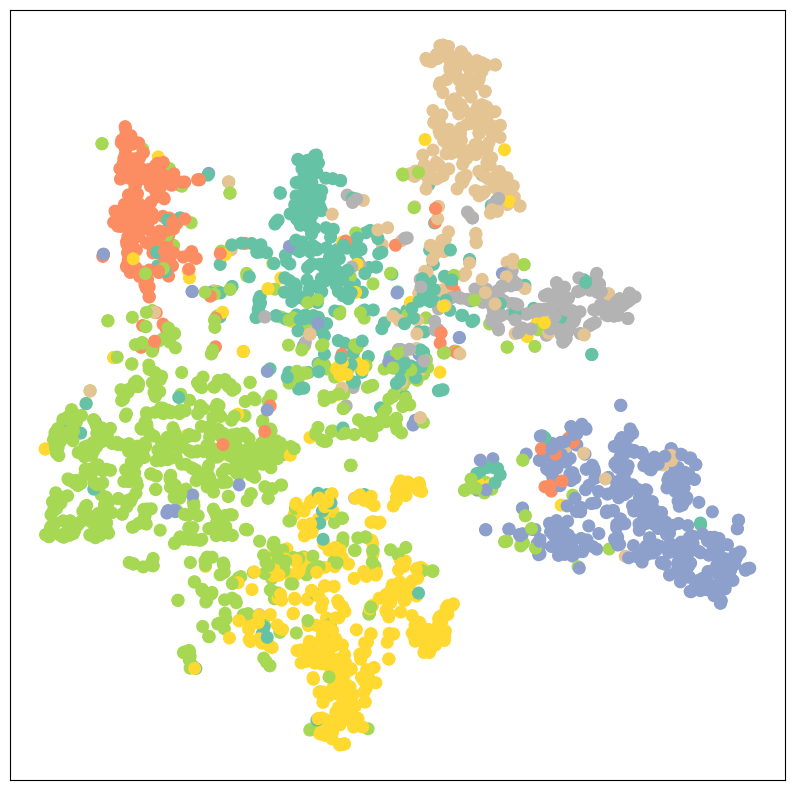

In [12]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [13]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # dropout: 元素以一定概率变成 0 ；剩下的元素放大，以保持总体期望不变
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16)
print(model)

GAT(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 7, heads=1)
)


In [14]:
model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9456
Epoch: 002, Loss: 1.9386
Epoch: 003, Loss: 1.9302
Epoch: 004, Loss: 1.9185
Epoch: 005, Loss: 1.9092
Epoch: 006, Loss: 1.8980
Epoch: 007, Loss: 1.8807
Epoch: 008, Loss: 1.8730
Epoch: 009, Loss: 1.8628
Epoch: 010, Loss: 1.8435
Epoch: 011, Loss: 1.8326
Epoch: 012, Loss: 1.8159
Epoch: 013, Loss: 1.8083
Epoch: 014, Loss: 1.7752
Epoch: 015, Loss: 1.7773
Epoch: 016, Loss: 1.7537
Epoch: 017, Loss: 1.7304
Epoch: 018, Loss: 1.7068
Epoch: 019, Loss: 1.6931
Epoch: 020, Loss: 1.6826
Epoch: 021, Loss: 1.6516
Epoch: 022, Loss: 1.6347
Epoch: 023, Loss: 1.6308
Epoch: 024, Loss: 1.5864
Epoch: 025, Loss: 1.5663
Epoch: 026, Loss: 1.5505
Epoch: 027, Loss: 1.5260
Epoch: 028, Loss: 1.5029
Epoch: 029, Loss: 1.4578
Epoch: 030, Loss: 1.4466
Epoch: 031, Loss: 1.4430
Epoch: 032, Loss: 1.4045
Epoch: 033, Loss: 1.3273
Epoch: 034, Loss: 1.3312
Epoch: 035, Loss: 1.3004
Epoch: 036, Loss: 1.2791
Epoch: 037, Loss: 1.2757
Epoch: 038, Loss: 1.2202
Epoch: 039, Loss: 1.1896
Epoch: 040, Loss: 1.1991


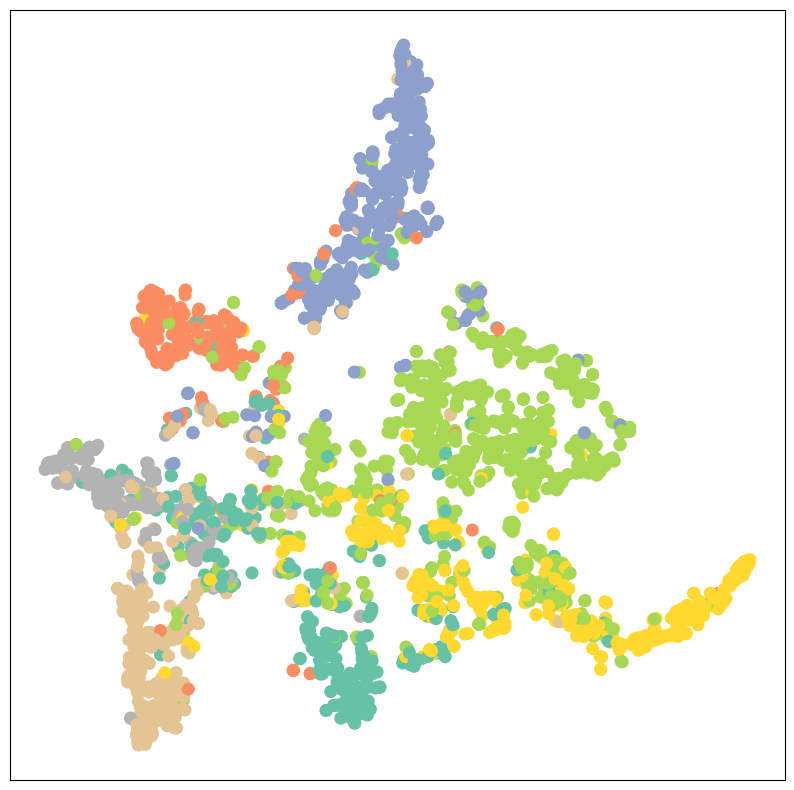

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [16]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)

        # First GAT layer: 8 attention heads, each with hidden_channels dimensions
        self.conv1 = GATConv(
            in_channels=dataset.num_features,
            out_channels=hidden_channels,
            heads=8,  # 8 attention heads
            dropout=0.6  # Internal dropout within GATConv
        )
        
        # Second GAT layer: 1 attention head
        self.conv2 = GATConv(
            in_channels=hidden_channels * 8,  # Concatenation of 8 heads from the previous layer
            out_channels=dataset.num_classes,
            heads=1,  # Single attention head
            concat=False,  # Do not concatenate the output of the final layer
            dropout=0.6  # Internal dropout within GATConv
        )

    def forward(self, x, edge_index):
        # First GAT layer with ReLU and external dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)  # External dropout

        # Second GAT layer with output
        x = self.conv2(x, edge_index)
        return x


# Instantiate the model with 8 hidden_channels per head
model = GAT(hidden_channels=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [17]:
model = GAT(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9371
Epoch: 003, Loss: 1.9248
Epoch: 004, Loss: 1.9171
Epoch: 005, Loss: 1.9043
Epoch: 006, Loss: 1.8917
Epoch: 007, Loss: 1.8757
Epoch: 008, Loss: 1.8638
Epoch: 009, Loss: 1.8512
Epoch: 010, Loss: 1.8363
Epoch: 011, Loss: 1.8333
Epoch: 012, Loss: 1.8122
Epoch: 013, Loss: 1.7802
Epoch: 014, Loss: 1.7744
Epoch: 015, Loss: 1.7427
Epoch: 016, Loss: 1.7200
Epoch: 017, Loss: 1.7041
Epoch: 018, Loss: 1.6355
Epoch: 019, Loss: 1.6529
Epoch: 020, Loss: 1.6181
Epoch: 021, Loss: 1.6156
Epoch: 022, Loss: 1.6408
Epoch: 023, Loss: 1.5936
Epoch: 024, Loss: 1.5392
Epoch: 025, Loss: 1.5168
Epoch: 026, Loss: 1.5558
Epoch: 027, Loss: 1.4567
Epoch: 028, Loss: 1.4652
Epoch: 029, Loss: 1.4324
Epoch: 030, Loss: 1.4262
Epoch: 031, Loss: 1.4283
Epoch: 032, Loss: 1.2970
Epoch: 033, Loss: 1.3307
Epoch: 034, Loss: 1.4332
Epoch: 035, Loss: 1.3382
Epoch: 036, Loss: 1.3101
Epoch: 037, Loss: 1.3008
Epoch: 038, Loss: 1.2334
Epoch: 039, Loss: 1.1995
Epoch: 040, Loss: 1.2459


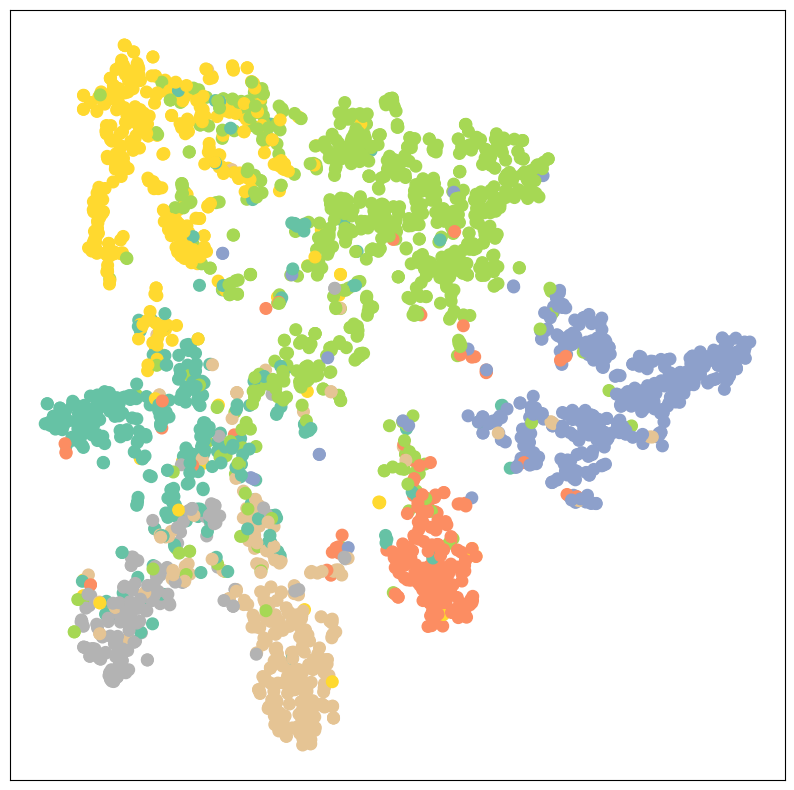

In [18]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)